In [1]:
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
from sklearn.metrics import roc_curve
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder
from utils import confusion_matrix as cm 

In [2]:
# Read data
train_data = pd.read_csv("../data/6_train_dataset_augmented.csv")
X_train = train_data.drop('is_fraud', axis=1)
y_train = train_data['is_fraud']

test_data = pd.read_csv("../data/4_test_dataset.csv")
X_test = test_data.drop('is_fraud', axis=1)
y_test = test_data['is_fraud']

In [3]:
N_FEATURES = len(X_train.columns)
N_FEATURES

21

In [4]:
# Binary encoding of labels
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)

encoder = LabelEncoder()
y_test = encoder.fit_transform(y_test)

In [5]:
# Convert to 2D PyTorch tensors
X_train = torch.tensor(X_train.values, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)

X_test = torch.tensor(X_test.values, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)

In [6]:
class Wide(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(N_FEATURES, 360)
        self.relu = nn.ReLU()
        self.output = nn.Linear(360, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.hidden(x))
        x = self.sigmoid(self.output(x))
        return x

class Deep(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(N_FEATURES, 60)
        self.act1 = nn.ReLU()
        self.layer2 = nn.Linear(60, 60)
        self.act2 = nn.ReLU()
        self.layer3 = nn.Linear(60, 60)
        self.act3 = nn.ReLU()
        self.output = nn.Linear(60, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.act2(self.layer2(x))
        x = self.act3(self.layer3(x))
        x = self.sigmoid(self.output(x))
        return x

In [7]:

# Compare model sizes
model1 = Wide()
model2 = Deep()
print(sum([x.reshape(-1).shape[0] for x in model1.parameters()]))
print(sum([x.reshape(-1).shape[0] for x in model2.parameters()]))

8281
8701


In [8]:

# Helper function to train one model
def model_train(model, X_train, y_train, X_val, y_val):
    # loss function and optimizer
    loss_fn = nn.BCELoss()  # binary cross entropy
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    n_epochs = 300   # number of epochs to run
    batch_size = 32  # size of each batch
    batch_start = torch.arange(0, len(X_train), batch_size)

    # Hold the best model
    best_recall = - np.inf   # init to negative infinity
    best_weights = None

    for epoch in range(n_epochs):
        model.train()
        with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
            bar.set_description(f"Epoch {epoch}")
            for start in bar:
                # take a batch
                X_batch = X_train[start:start+batch_size]
                y_batch = y_train[start:start+batch_size]
                # forward pass
                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch)
                # backward pass
                optimizer.zero_grad()
                loss.backward()
                # update weights
                optimizer.step()
                # print progress
                _,_,(_,recall,_,_) = cm.get_confusion_matrix(y_batch.detach().numpy(), y_pred.round().detach().numpy())
                acc = (y_pred.round() == y_batch).float().mean()
                bar.set_postfix(
                    loss=float(loss),
                    acc=float(acc),
                    recall=float(recall)
                )
        # evaluate recall at end of each epoch
        model.eval()
        y_pred = model(X_val)
        acc = (y_pred.round() == y_val).float().mean()
        acc = float(acc)
        _,_,(_,recall,_,_) = cm.get_confusion_matrix(y_val.detach().numpy(), y_pred.round().detach().numpy())
        recall = float(recall)

        if recall > best_recall:
            best_recall = recall
            best_weights = copy.deepcopy(model.state_dict())
    # restore model and return best recall
    model.load_state_dict(best_weights)
    return best_recall

In [ ]:
# define 5-fold cross validation test harness
kfold = StratifiedKFold(n_splits=5, shuffle=True)
cv_scores_wide = []
for train, test in kfold.split(X_train, y_train):
    # create model, train, and get recall
    model = Wide()
    recall = model_train(model, X_train[train], y_train[train], X_train[test], y_train[test])
    print("Recall (wide): %.2f" % recall)
    cv_scores_wide.append(recall)
cv_scores_deep = []
for train, test in kfold.split(X_train, y_train):
    # create model, train, and get recall
    model = Deep()
    recall = model_train(model, X_train[train], y_train[train], X_train[test], y_train[test])
    print("Recall (deep): %.2f" % recall)
    cv_scores_deep.append(recall)

# evaluate the model
wide_recall = np.mean(cv_scores_wide)
wide_std = np.std(cv_scores_wide)
deep_recall = np.mean(cv_scores_deep)
deep_std = np.std(cv_scores_deep)
print("Wide: %.2f%% (+/- %.2f%%)" % (wide_recall*100, wide_std*100))
print("Deep: %.2f%% (+/- %.2f%%)" % (deep_recall*100, deep_std*100))

# rebuild model with full set of training data
if wide_recall > deep_recall:
    print("Retrain a wide model")
    model = Wide()
else:
    print("Retrain a deep model")
    model = Deep()
recall = model_train(model, X_train, y_train, X_test, y_test)
print(f"Final model recall: {recall*100:.2f}%")

Recall (wide): 0.99


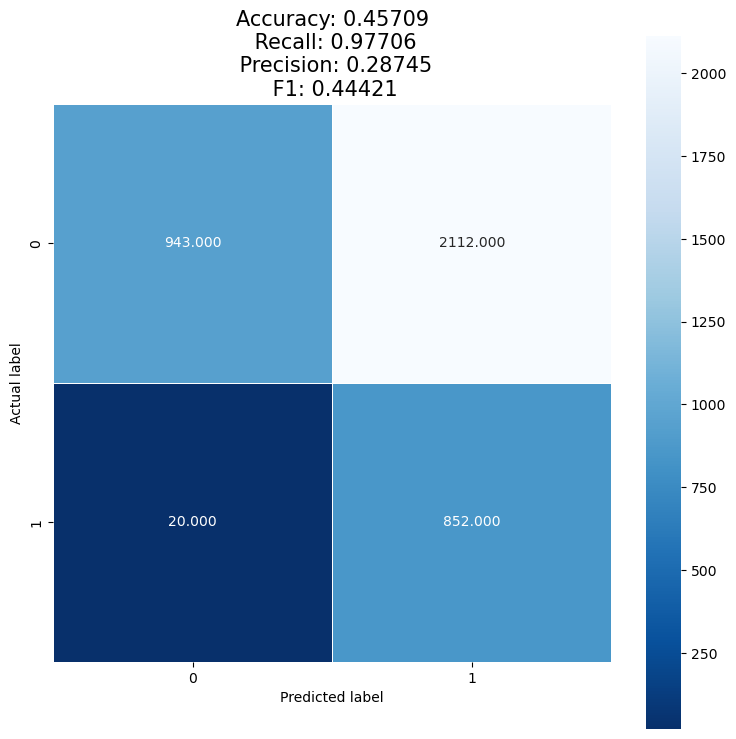

In [13]:
actuals = y_test.detach().numpy()
predictions = model(X_test)
predictions = predictions.round().detach().numpy()

plt.figure(figsize=(9,9))
nn_cm,_,(nn_accuracy, nn_recall, nn_precision,nn_f1) = cm.get_confusion_matrix(actuals, predictions)
sns.heatmap(nn_cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy: {0:.5f}\n Recall: {1:.5f}\n Precision: {2:.5f}\n F1: {3:.5f}'.format(nn_accuracy,nn_recall, nn_precision, nn_f1)
plt.title(all_sample_title, size=15)
plt.show()

In [14]:
torch.save(model.state_dict(), '../models/neural_networks_ii.pt')
